In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# import pickle

In [2]:
frames_count = os.listdir("C:\\PGDAI\\Project\\Self Development\\Try_2\\training\\frames")
print(len(frames_count))
images_count = os.listdir("C:\\PGDAI\\Project\\Self Development\\Try_2\\training\\lane-masks")
print(len(images_count))
print(frames_count)
print(images_count)
assert frames_count == images_count

3000
3000
['0313-1_15140.jpg', '0313-1_15160.jpg', '0313-1_15180.jpg', '0313-1_15200.jpg', '0313-1_15220.jpg', '0313-1_15240.jpg', '0313-1_15260.jpg', '0313-1_15280.jpg', '0313-1_15300.jpg', '0313-1_15320.jpg', '0313-1_15340.jpg', '0313-1_15360.jpg', '0313-1_15380.jpg', '0313-1_15400.jpg', '0313-1_15420.jpg', '0313-1_15440.jpg', '0313-1_15460.jpg', '0313-1_15480.jpg', '0313-1_15500.jpg', '0313-1_15520.jpg', '0313-1_15540.jpg', '0313-1_15560.jpg', '0313-1_15580.jpg', '0313-1_15600.jpg', '0313-1_15620.jpg', '0313-1_15640.jpg', '0313-1_15660.jpg', '0313-1_15680.jpg', '0313-1_15700.jpg', '0313-1_15720.jpg', '0313-1_15740.jpg', '0313-1_15760.jpg', '0313-1_15780.jpg', '0313-1_15800.jpg', '0313-1_15820.jpg', '0313-1_15840.jpg', '0313-1_15860.jpg', '0313-1_15880.jpg', '0313-1_15900.jpg', '0313-1_15920.jpg', '0313-1_15940.jpg', '0313-1_15960.jpg', '0313-1_15980.jpg', '0313-1_16000.jpg', '0313-1_16020.jpg', '0313-1_16040.jpg', '0313-1_16060.jpg', '0313-1_16080.jpg', '0313-1_16100.jpg', '0313-1_1

In [3]:
def load_images(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []

    image_files = sorted(os.listdir(image_dir))  # Ensure proper order
    mask_files = sorted(os.listdir(mask_dir))  

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size) / 255.0  # Normalize

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        mask = cv2.resize(mask, img_size) / 255.0  # Normalize
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Paths to your dataset
image_dir = "C:\\PGDAI\\Project\\Self Development\\Try_2\\training\\frames"
mask_dir = "C:\\PGDAI\\Project\\Self Development\\Try_2\\training\\lane-masks"

# Load dataset
X, y = load_images(image_dir, mask_dir)

# Split into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Save dataset as compressed .npz file
np.savez_compressed("dataset_split.npz", 
                    X_train=X_train, X_val=X_val, 
                    y_train=y_train, y_val=y_val)

print("Dataset saved successfully as .npz")


# # Define file path
# pickle_filename = "C:\\PGDAI\\Project\\Self Development\\Try_2\\training\\dataset_split.pkl"

# # Save (dump) the variables
# with open(pickle_filename, "wb") as f:
#     pickle.dump((X_train, X_val, y_train, y_val), f)

# print(f"Dataset saved to {pickle_filename}")

# # Pickle the model
# with open('X_train.pkl', 'wb') as train_X:
#     pickle.dumps(X_train)
# # train_X = open('X_train.pkl', 'w')
# # pickle.dump(X_train,train_X)

# # Pickle the model
# with open('y_train.pkl', 'wb') as train_y:
#     pickle.dumps(y_train)
# # train_y = open('y_train.pkl', 'w')
# # pickle.dump(y_train,train_y)

# # Pickle the model
# with open('X_val.pkl', 'wb') as val_X:
#     pickle.dumps(X_val)
# # val_X = open('X_val.pkl', 'w')
# # pickle.dump(X_val,val_X)

# # Pickle the model
# with open('y_val.pkl', 'wb') as val_y:
#     pickle.dumps(y_val)
# # val_y = open('y_val.pkl', 'w')
# # pickle.dump(y_val,val_y)

In [4]:
def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation="relu", padding="same")(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation="relu", padding="same")(p3)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(128, (3, 3), activation="relu", padding="same")(u1)

    u2 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(64, (3, 3), activation="relu", padding="same")(u2)

    u3 = UpSampling2D((2, 2))(c6)
    c7 = Conv2D(32, (3, 3), activation="relu", padding="same")(u3)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c7)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

    return model


In [5]:
model = build_unet()
model.summary()

# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=10)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,745 (2.96 MB)

 Trainable params: 775,745 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 262s 860ms/step - accuracy: 0.9282 - loss: 0.1898 - val_accuracy: 0.9529 - val_loss: 0.0886
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 238s 793ms/step - accuracy: 0.9543 - loss: 0.0814 - val_accuracy: 0.9566 - val_loss: 0.0701
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 240s 799ms/step - accuracy: 0.9573 - loss: 0.0685 - val_accuracy: 0.9575 - val_loss: 0.0646
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 237s 789ms/step - accuracy: 0.9585 - loss: 0.0631 - val_accuracy: 0.9586 - val_loss: 0.0608
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 236s 788ms/step - accuracy: 0.9591 - loss: 0.0596 - val_accuracy: 0.9590 - val_loss: 0.0597
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 236s 788ms/step - accuracy: 0.9599 - loss: 0.0569 - val_accuracy: 0.9596 - val_loss: 0.0576
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 238s 792ms/step - accuracy: 0.9602 - loss: 0.0547 - val_accuracy: 0.9597 - val_loss: 0.0566
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 237s 788ms/step - accuracy: 0.9605 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


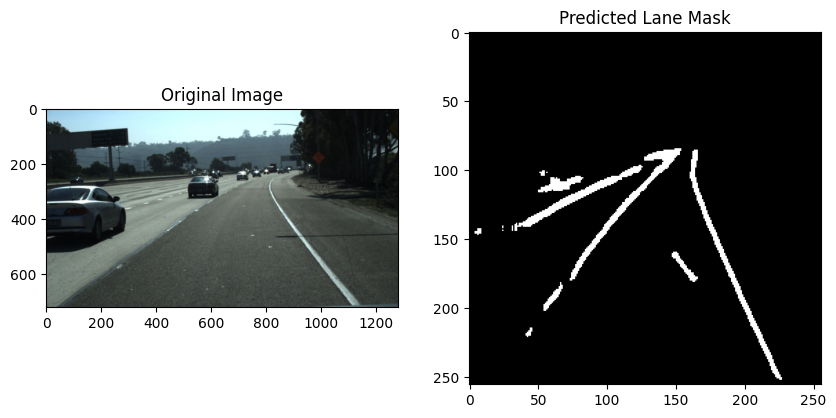

In [6]:
def predict_and_visualize(model, img_path):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (256, 256)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    pred_mask = model.predict(img_input)[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Lane Mask")
    plt.show()

# Test
test_img = "C:\\PGDAI\\Project\\Self Development\\Try_2\\Testing\\frames\\0313-1_120.jpg"
predict_and_visualize(model, test_img)

In [7]:
model.save("lane_detection_unet.keras")

In [8]:
from tensorflow.keras.metrics import MeanIoU

# Compute IoU
def compute_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    iou_metric = MeanIoU(num_classes=2)
    iou_metric.update_state(y_true, y_pred)
    return iou_metric.result().numpy()

# Compute Dice Coefficient
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

# Evaluate on validation set
y_pred_val = model.predict(X_val)
iou_score = compute_iou(y_val, y_pred_val)
dice_score = dice_coefficient(y_val, y_pred_val)

print(f"IoU Score: {iou_score:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
IoU Score: 0.7098
Dice Coefficient: 0.7185
